# **Analysis of Titanic Dataset with PYCARET**

   Today in my notebook, i am going to talk about PYCARET which is an AutoML tool. When applying machine learning models, we usually do data preprocessing, feature extraction, and feature selection. After these steps, we choose the best algorithm and optimize our parameters to achieve the best results. There are many automatic machine learning tools that we call AutoML to reduce this load. Today, I will review PyCaret, one of these tools, and make a classification example with PyCaret.

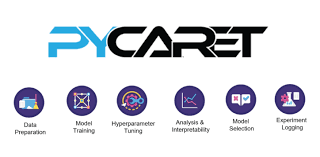

PyCaret is a Python library that aims to reduce trial and error processes and be more productive of data scientists. It's basically a Python library that surrounds scikit-learn, XGBoost, LightGBM, and many more machine learning libraries and frameworks.

PyCaret includes modules for some Machine Learning tasks given below.
- Classification
- Regression
- Clustering
- Anomaly Detection
- Naturel Language Processing
- Association Rule Mining

If you want to see more detail about PyCaret, you can reach it from the link. https://pycaret.org/

You can easily download pycaret with the above command.
> !pip install pycaret

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install pycaret

First, I will include the required libraries in the code.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import pycaret
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')
sub = pd.read_csv('../input/titanic/gender_submission.csv')

Now let's see what the dataset looks like.

In [ ]:
train.head()

In [ ]:
train.info()

In [ ]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)

    print("##################### Types #####################")
    print(dataframe.dtypes)

    print("##################### Head #####################")
    print(dataframe.head(head))

    print("##################### Tail #####################")
    print(dataframe.tail(head))

    print("##################### NA #####################")
    print(dataframe.isnull().sum())

    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [ ]:
check_df(train)

In [ ]:
def cat_summary(dataframe, col_name, plot=False):

    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

Here we will try to predict the Survived column.  In this column, 1 indicates survivors and 0 death ones in Titanic. Let's examine the ratio of these two situations with a graph.

In [ ]:
cat_summary(train, "Survived", plot=True)

Now let's observe which machine learning algorithm will work better with the help of PyCaret. We will examine this problem as part of the classification problem. Therefore, I import PyCaret's classification modules and specify our target column and categorical variables with the setup.

In [ ]:
from pycaret.classification import *

In [ ]:
clf1 = setup(data = train, 
             target = 'Survived',
             numeric_imputation = 'mean',
             categorical_features = ['Sex','Embarked'], 
             ignore_features = ['Name','Ticket','Cabin'],
             silent = True
             )

There are many settings in the **setup** function. We can use these properties according to the problem. After this process, we can see which model will bring the best results with **compare_model()**. From the results below it clearly appears that the best results come with **catboost**. These results may vary slightly as the code is applied. These differences are normal since we randomly divide the data into pieces and apply algorithms.

In [ ]:
compare_models()

After examining the table, I decided to implement CatBoost Classifier.

In [ ]:
catboost  = create_model('catboost') 

Now I want this model to find **the best parameters** and return a result according to those parameters. I will use the following code snippet for this.

In [ ]:
tuned_cat = tune_model(catboost)

The accuracy value increases when the best parameters are set. Now let's observe the values with data visualization tools.

In [ ]:
plot_model(estimator = tuned_cat, plot = 'learning')

In [ ]:
plot_model(estimator = tuned_cat, plot = 'auc')

The results in the second graph show that the model's success is satisfying. Let's observe it with the confusion matrix as we understand it.

In [ ]:
plot_model(estimator = tuned_cat, plot = 'confusion_matrix')

Let's see how effective the features that affect this model are on the model. The top-ranked features have more impact on the model.

In [ ]:
plot_model(estimator = tuned_cat, plot = 'feature')

In [ ]:
interpret_model(tuned_cat)

In this part, I conclude that it might be better if we look at the **Feature** graphics above and delete some features. I will remove the SibSp, Parch columns from the model and observe the results again. Additionally, I also change the **remove_outliers** property to True. If there is an outlier, I want it to take action on it as well.

In [ ]:
clf2 = setup(data = train, 
             target = 'Survived',
             numeric_imputation = 'mean',
             categorical_features = ['Sex','Embarked'], 
             ignore_features = ['Name','Ticket','Cabin','SibSp','Parch'],
             silent = True,
             remove_outliers=True
             )

In [ ]:
compare_models()

In [ ]:
cat2  = create_model('catboost')   

In [ ]:
tuned_cat2 = tune_model(cat2)

In [ ]:
plot_model(estimator = tuned_cat2, plot = 'learning')

In [ ]:
plot_model(estimator = tuned_cat2, plot = 'auc')

In [ ]:
plot_model(estimator = tuned_cat2, plot = 'confusion_matrix')

Looking at the results, it seems that removing the less active features and dealing with outliers did not have a huge impact on our model. We can deduce from these results that we have obtained a usable model in its initial state too.

 In addition to all this, PyCaret allows us to apply multiple models to the dataset. I will show this with a short example. We can implement multiple models using the blend_models() function. In this case, the first two or three algorithms that give the best results on the first try are usually chosen. As a result, we see an increase of 1%.

In [ ]:
light  = create_model('lightgbm');
gbc = create_model('gbc');
blend = blend_models(estimator_list=[tuned_cat2,light,gbc])

In [ ]:
tuned_blend = tune_model(blend)

In [ ]:
plot_model(estimator = blend, plot = 'learning')

In [ ]:
plot_model(estimator = blend, plot = 'auc')

In [ ]:
plot_model(estimator = blend, plot = 'confusion_matrix')

In [ ]:
predictions = predict_model(blend, data=test)
predictions.head()

In [ ]:
sub['Survived'] = round(predictions['Score']).astype(int)
sub.to_csv('submission.csv',index=False)
sub.head()

In summary, PyCaret is an easy-to-use library. It helps developers from the beginning of data preparation to model analysis. It has lots of open source algorithms, visualization tools, and preprocessing techniques. In cases where we are undecided about which machine learning algorithm to apply to any data set, we can use the PyCaret library when we want to find the best parameters of the machine learning model we have chosen.
I hope this post about PyCaret was helpful. Goodbye :)